$$ ITI \space AI-Pro: \space Intake \space 45 $$
$$ Deep \space Learning $$
$$ Lab \space no. \space 4 $$

# `01` Assignment 01
- Design your own U-Net to segment the lung fields from chest computed tomography CT images (download from [here](https://drive.google.com/file/d/1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9/view?usp=sharing)) into one of the 2 classes lung or chest (background)
- Image Size: $512\times512\times1$
- Use a generator to load the images
(**Hint:** You can use `tensorflow.keras.utils.image_dataset_from_directory`)
- Use 85% of the provided data for training and 15% for validation.
- Use $32 → 64 → 128 → 256 → 512 → 256 → 128 → 64 → 32$ architecture.
- Use $3\times3$ **Convolution**, $2\times2$ **MaxPooling**
- Use `binary_crossentropy` for the loss calculation, `Adam` for optimization and `accuracy` for metrics.

## `+` Import Libraries

In [ ]:
import gdown

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image_dataset_from_directory
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import MaxPooling2D
from keras.layers import Conv2DTranspose, Concatenate
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, Lambda
from keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, Flatten,GlobalMaxPooling2D,GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import os
from tensorflow.keras.layers import Dense, BatchNormalization, Input, Dropout


# `+` Seed Value

In [ ]:
SEED = 524

## `+` Downlaod, Load & Preprocess Chest CT Data

### Download & Extract the Dataset

In [ ]:
gdown.download(id='1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9')

Downloading...
From (original): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9
From (redirected): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9&confirm=t&uuid=33729552-76d6-4d2e-8b9a-14383827e8d2
To: /content/Lung_Data.zip
100%|██████████| 41.1M/41.1M [00:00<00:00, 234MB/s]


'Lung_Data.zip'

In [ ]:
%%capture
!unzip Lung_Data.zip

### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [ ]:
BATCH_SIZE=8

In [ ]:
folders = ['grey', 'mask']
for folder in folders:
    out_dir = f'Lung_Data_PNG/{folder}'
    os.makedirs(out_dir, exist_ok=True)
    for img in glob(f'Lung_Data/{folder}/*.bmp'):
        Image.open(img).save(os.path.join(out_dir, img.split('/')[-1].rsplit('.', maxsplit=1)[0] + '.png'), 'PNG')

In [ ]:
# Training & Validation for gray images
gray_train_ds, gray_val_ds = image_dataset_from_directory('Lung_Data_PNG/grey',batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(512, 512),
                                                color_mode="grayscale",
                                                labels=None,
                                                validation_split=0.15,
                                                subset="both")

Found 216 files.
Using 184 files for training.
Using 32 files for validation.


In [ ]:
# Training & Validation for mask images
mask_train_ds, mask_val_ds = image_dataset_from_directory('Lung_Data_PNG/mask',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(512, 512),
                                                color_mode="grayscale",
                                                labels=None,
                                                validation_split=0.15,subset="both")

Found 216 files.
Using 184 files for training.
Using 32 files for validation.


### Preview the Images

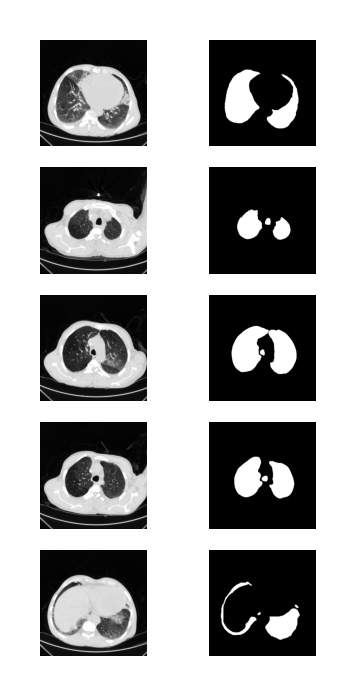

In [ ]:
# preview images for Training Dataset
plt.figure(figsize=(1, 2), dpi=400)
for images, masks in zip(gray_train_ds.take(4), mask_train_ds.take(4)):
    for i in range(5):
        plt.subplot(5, 2, i*2+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.subplot(5, 2, i*2+2)
        plt.imshow(masks[i], cmap='gray')
        plt.axis('off')


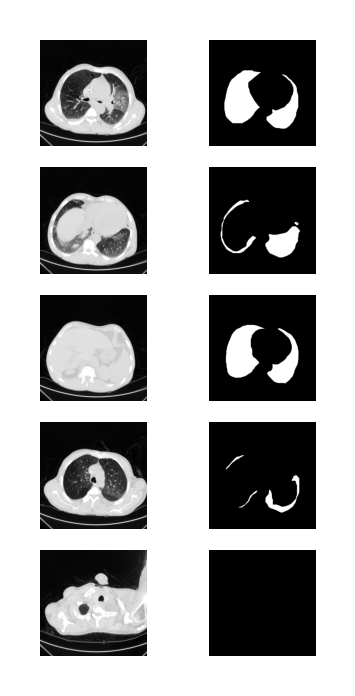

In [ ]:
# preview images for Validation Dataset
plt.figure(figsize=(1, 2), dpi=400)
for images, masks in zip(gray_val_ds.take(4), mask_train_ds.take(4)):
    for i in range(5):
        plt.subplot(5, 2, i*2+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.subplot(5, 2, i*2+2)
        plt.imshow(masks[i], cmap='gray')
        plt.axis('off')



## `+` Set Global Parameters

In [ ]:
# Hyperparameters
EPOCHS = 15

- Use $32 → 64 → 128 → 256 → 512 → 256 → 128 → 64 → 32$ architecture.
- Use $3\times3$ **Convolution**, $2\times2$ **MaxPooling**
- Use `binary_crossentropy` for the loss calculation, `Adam` for optimization and `accuracy` for metrics.

## `i` Model Design

In [ ]:
def double_conv(x,n_filters):
  x=keras.layers.Conv2D(n_filters,(3,3),padding='same',activation='relu',kernel_initializer='he_normal')(x)
  x=keras.layers.Conv2D(n_filters,(3,3),padding='same',activation='relu',kernel_initializer='he_normal')(x)
  return x

In [ ]:
def Downsampling_block(x,n_filters):
  feature_skip=double_conv(x,n_filters)
  pool_output=keras.layers.MaxPooling2D((2,2))(feature_skip)
  return feature_skip,pool_output



In [ ]:
def Upsample_block(x, n_filters, feature_skip):
    x = Conv2DTranspose(n_filters, (3, 3), strides=2, padding='same')(x)
    concat = Concatenate()([x, feature_skip])
    x = double_conv(concat, n_filters)
    return x

## `ii` Model Compilation & Training

In [ ]:
# Input
inputs=Input(shape=(512,512,1))
# Rescaling
scaled_feature=Rescaling(1./255)(inputs)

#Encoder
feature_skip1,pool_output1=Downsampling_block(scaled_feature,32)
feature_skip2,pool_output2=Downsampling_block(pool_output1,64)
feature_skip3,pool_output3=Downsampling_block(pool_output2,128)
feature_skip4,pool_output4=Downsampling_block(pool_output3,256)


# Bottleneck
Bottleneck=double_conv(pool_output4,512)

#Decoder

up_sample4=Upsample_block(Bottleneck,256,feature_skip4)
up_sample3=Upsample_block(up_sample4,128,feature_skip3)
up_sample2=Upsample_block(up_sample3,64,feature_skip2)
up_sample1=Upsample_block(up_sample2,32,feature_skip1)

#output
outputs=Conv2D(1,(1,1),activation='sigmoid')(up_sample1)



In [ ]:

model_u_net = Model(inputs, outputs, name='My_Unet_model_lung')

model_u_net.summary()

Model: "My_Unet_model_lung"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        320 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │  1,179,904 │ conv2d_9[0][0]  

 Total params: 8,629,921 (32.92 MB)

 Trainable params: 8,629,921 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_data = tf.data.Dataset.zip(gray_train_ds, mask_train_ds.map(lambda x: Rescaling(1./255)(x)))
val_data = tf.data.Dataset.zip(gray_val_ds, mask_val_ds.map(lambda x: Rescaling(1./255)(x)))

In [ ]:
# EPOCHS=50

In [ ]:
model_u_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
hist1=model_u_net.fit(x=train_data,epochs=EPOCHS,validation_data=val_data,callbacks=[early_stopping],steps_per_epoch=gray_train_ds.cardinality().numpy(), validation_steps=gray_val_ds.cardinality().numpy())

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7796 - loss: 0.5477 - val_accuracy: 0.9045 - val_loss: 0.3648
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 69s 610ms/step - accuracy: 0.8877 - loss: 0.4898 - val_accuracy: 0.9045 - val_loss: 0.3557
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 643ms/step - accuracy: 0.8851 - loss: 0.4083 - val_accuracy: 0.9045 - val_loss: 0.2611
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 627ms/step - accuracy: 0.8867 - loss: 0.2836 - val_accuracy: 0.9045 - val_loss: 0.2462
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 664ms/step - accuracy: 0.8890 - loss: 0.2609 - val_accuracy: 0.9045 - val_loss: 0.1986
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 644ms/step - accuracy: 0.8852 - loss: 0.2628 - val_accuracy: 0.9045 - val_loss: 0.2726
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 635ms/step - accuracy: 0.8859 - loss: 0.2760 - val_accuracy: 0.9045 - val_loss: 0.2124
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 627ms/step - accuracy: 0.8908 - loss: 0.2472 - val_accurac

## `iii` Model Evaluation

In [ ]:
loss,accuracy=model_u_net.evaluate(train_data)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.8891 - loss: 0.2468
Loss: 0.24853543937206268
Accuracy: 0.8898061513900757


In [ ]:
lo,acc=model_u_net.evaluate(val_data)
print(f"Loss: {lo}")
print(f"Accuracy: {acc}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.8981 - loss: 0.2058
Loss: 0.1985972672700882
Accuracy: 0.9045267105102539


## `iv` Result Visualization

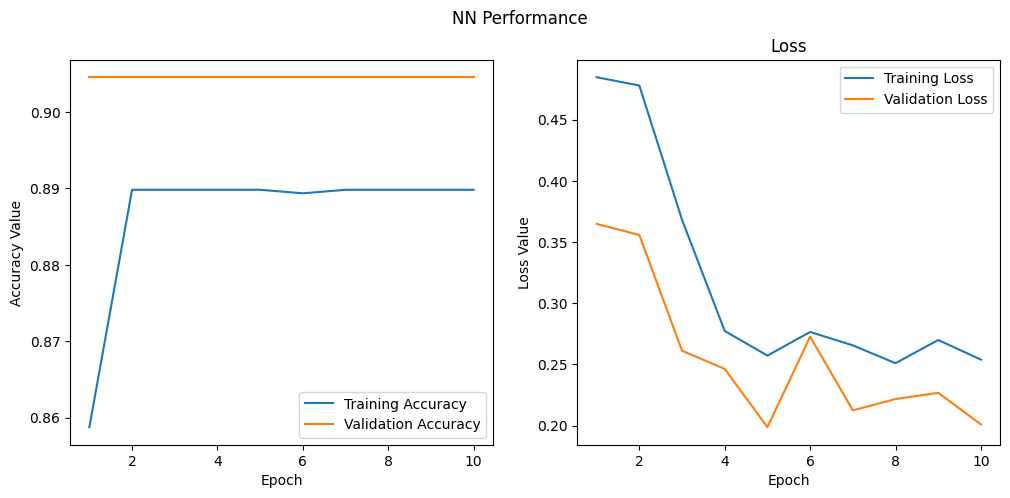

In [ ]:
epochs = range(1, len(hist1.history['accuracy']) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(epochs, hist1.history['accuracy'], label='Training Accuracy')
ax[0].plot(epochs, hist1.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy Value')
ax[0].legend()



ax[1].plot(epochs,hist1.history['loss'], label='Training Loss')
ax[1].plot(epochs, hist1.history['val_loss'], label='Validation Loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss Value')
ax[1].legend()

fig.suptitle('NN Performance')

plt.show();

## `v` It's Time for Segmentation!!

Let's try to predict the mask of some validation samples and plot the results.

In [ ]:
preds = model_u_net.predict(list(gray_train_ds.take(3))[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


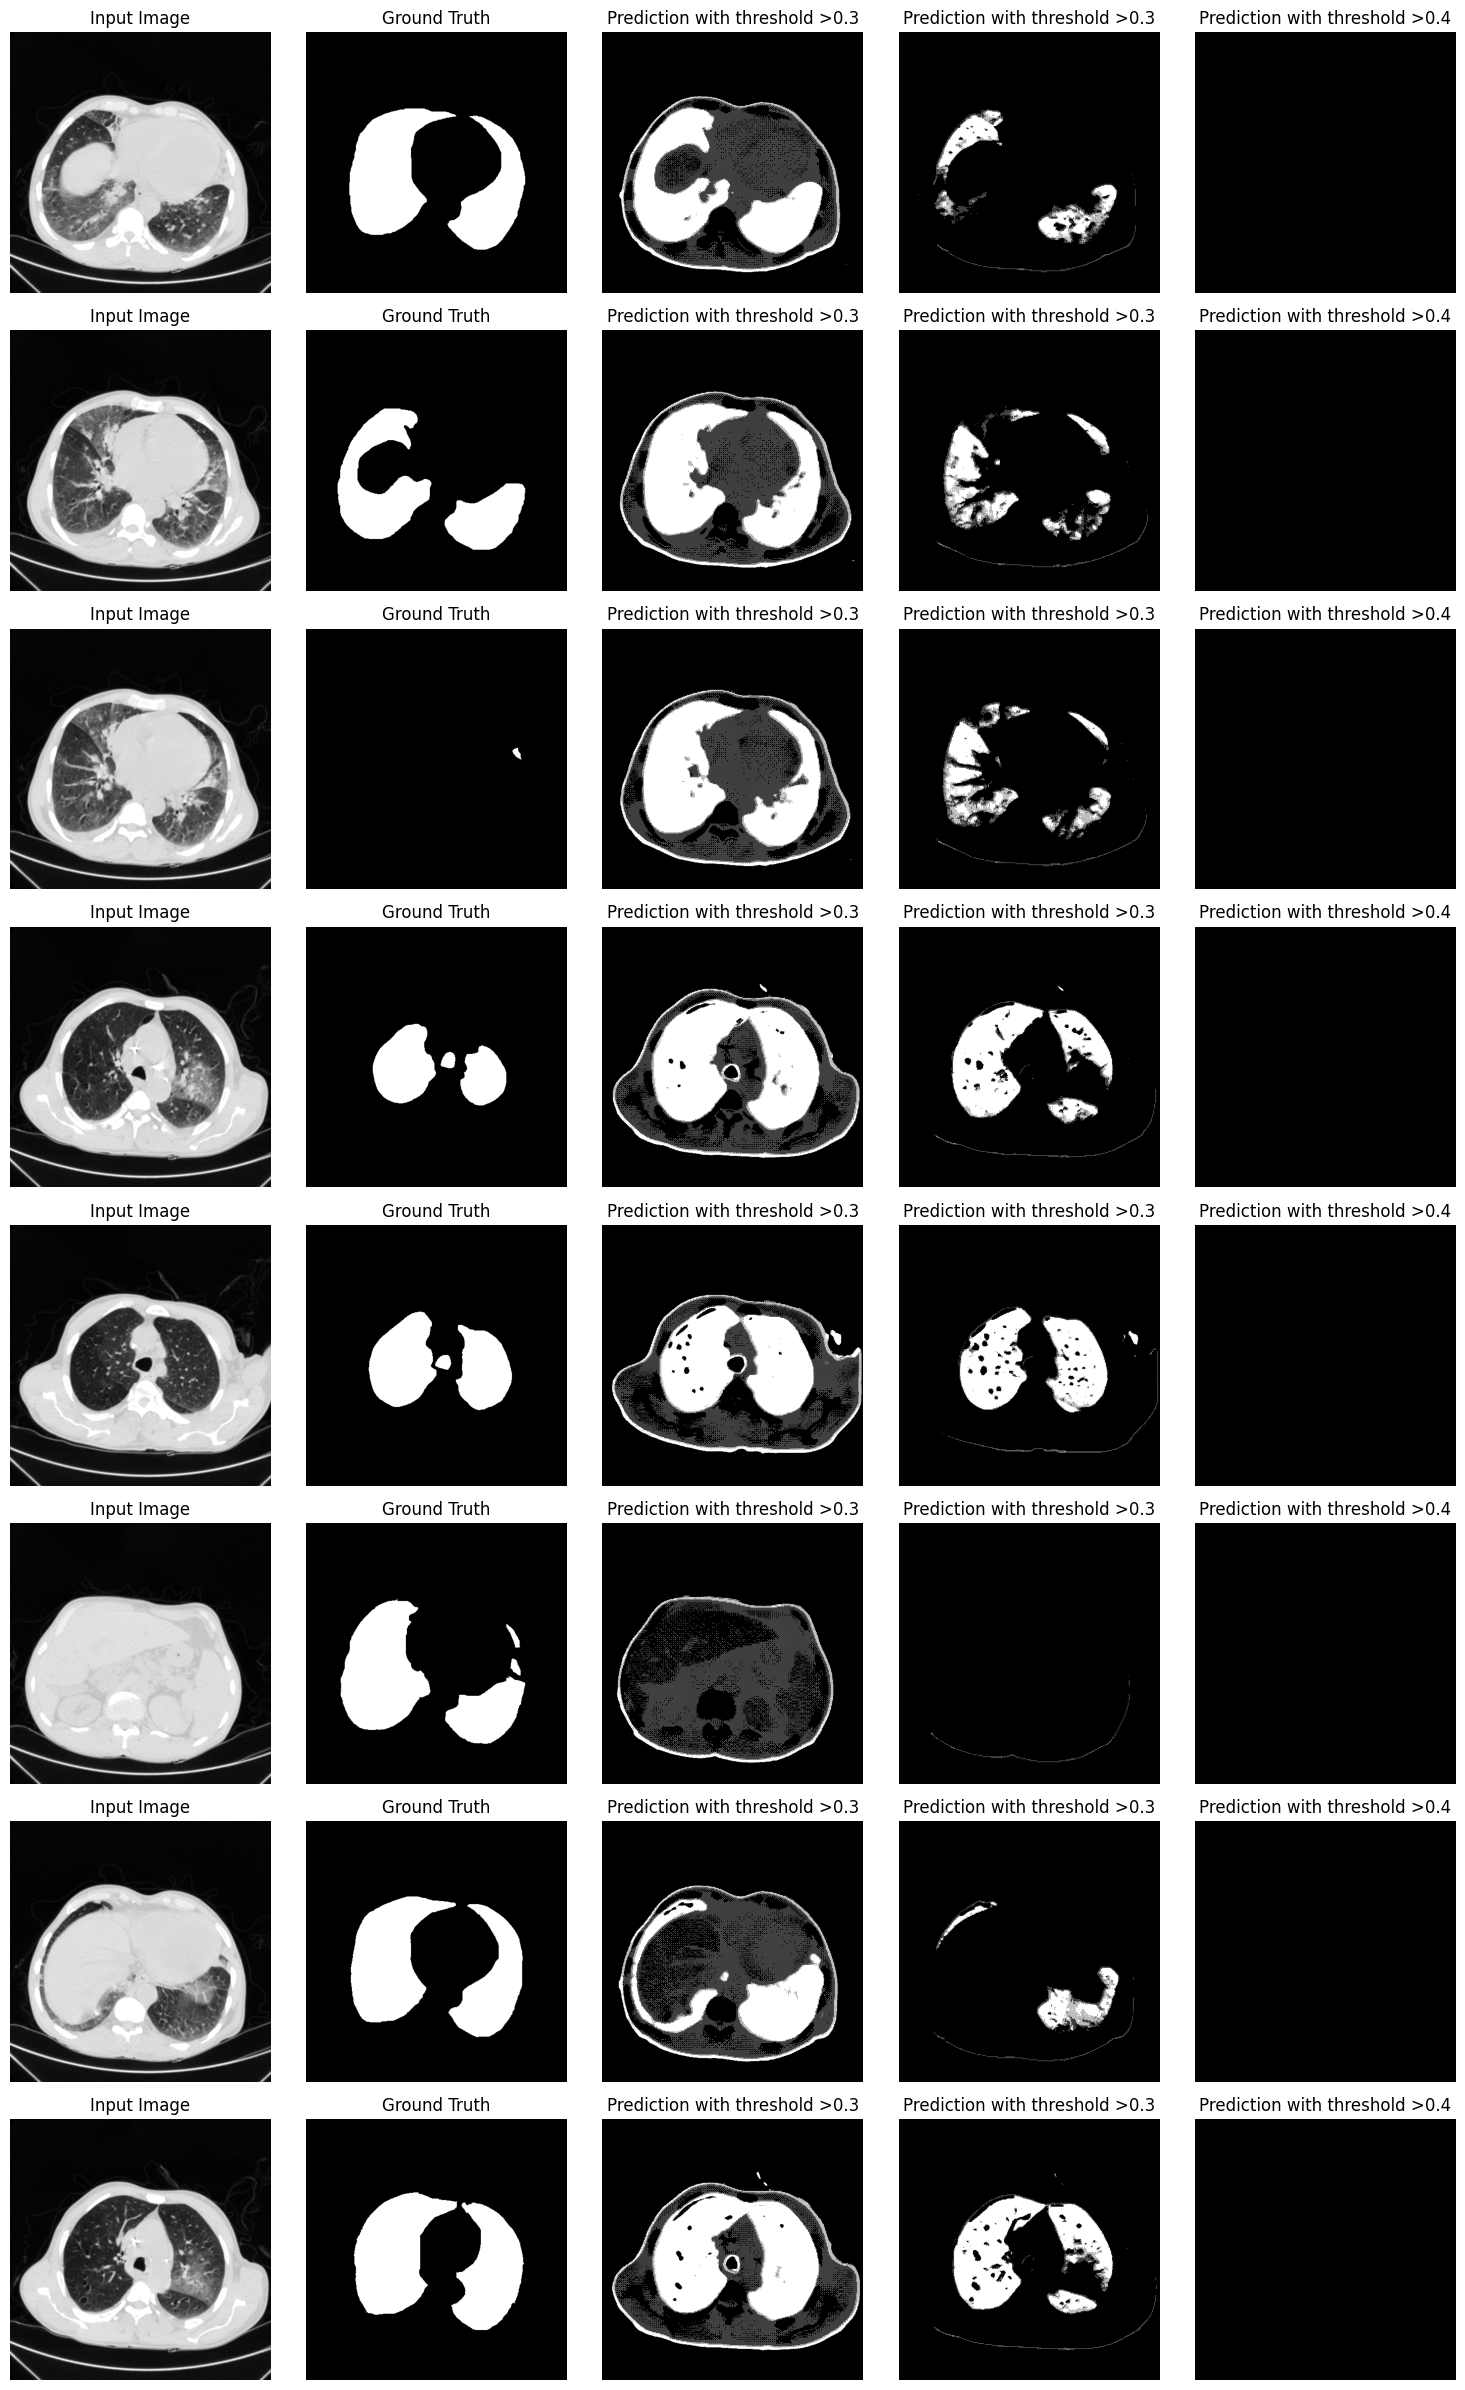

In [ ]:
for images, masks in train_data.take(1):
    preds = model_u_net.predict(images)

    num_images = min(10, images.shape[0])
    fig, axes = plt.subplots(num_images, 5, figsize=(15, num_images * 3))

    for i in range(num_images):
        # Input image
        axes[i, 0].imshow(images[i].numpy().squeeze(), cmap='gray')
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis('off')

        # Ground Truth Mask
        axes[i, 1].imshow(masks[i].numpy().squeeze(), cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')

        # Predicted Mask
        pred_mask = preds[i].squeeze()
        pred_mask1 = (pred_mask > 0.2).astype(np.uint8)
        axes[i, 2].imshow(pred_mask1, cmap='gray')

        axes[i, 2].set_title("Prediction with threshold >0.3")
        axes[i, 2].axis('off')



        # Predicted Mask
        pred_mask = preds[i].squeeze()
        pred_mask2 = (pred_mask > 0.3).astype(np.uint8)
        axes[i, 3].imshow(pred_mask2, cmap='gray')

        axes[i, 3].set_title("Prediction with threshold >0.3")
        axes[i, 3].axis('off')


          # Predicted Mask
        pred_mask = preds[i].squeeze()
        pred_mask3 = (pred_mask > 0.4).astype(np.uint8)
        axes[i, 4].imshow(pred_mask3, cmap='gray')

        axes[i, 4].set_title("Prediction with threshold >0.4")
        axes[i, 4].axis('off')



    plt.tight_layout()
    plt.show()



### Another Trail

In [ ]:
def double_conv_2(x,n_filters):
  x=keras.layers.Conv2D(n_filters,(3,3),padding='same',activation=None,kernel_initializer='he_normal')(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.Activation('relu')(x)
  x=keras.layers.Conv2D(n_filters,(3,3),padding='same',activation=None,kernel_initializer='he_normal')(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.Activation('relu')(x)
  return x

In [ ]:
def Downsampling_block2(x,n_filters):
  feature_skip=double_conv_2(x,n_filters)
  pool_output=keras.layers.MaxPooling2D((2,2))(feature_skip)
  return feature_skip,pool_output


In [ ]:
# Input
inputs=Input(shape=(512,512,1))
# Rescaling
scaled_feature=Rescaling(1./255)(inputs)

#Encoder
feature_skip1,pool_output1=Downsampling_block2(scaled_feature,32)
feature_skip2,pool_output2=Downsampling_block2(pool_output1,64)
feature_skip3,pool_output3=Downsampling_block2(pool_output2,128)
feature_skip4,pool_output4=Downsampling_block2(pool_output3,256)


# Bottleneck
Bottleneck=double_conv_2(pool_output4,512)

#Decoder

up_sample4=Upsample_block(Bottleneck,256,feature_skip4)
up_sample3=Upsample_block(up_sample4,128,feature_skip3)
up_sample2=Upsample_block(up_sample3,64,feature_skip2)
up_sample1=Upsample_block(up_sample2,32,feature_skip1)

#output
outputs=Conv2D(1,(1,1),activation='sigmoid')(up_sample1)



In [ ]:

model_2= Model(inputs, outputs, name='My_Unet_model_lung')

model_2.summary()

Model: "My_Unet_model_lung"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 512, 512,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 512, 512,  │        320 │ rescaling_5[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        128 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 512, 512,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 256, 256,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_5[

 Total params: 8,637,857 (32.95 MB)

 Trainable params: 8,633,889 (32.94 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [ ]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist2=model_2.fit(x=train_data,epochs=EPOCHS,validation_data=val_data,callbacks=[early_stopping],steps_per_epoch=gray_train_ds.cardinality().numpy(), validation_steps=gray_val_ds.cardinality().numpy())

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 623ms/step - accuracy: 0.9612 - loss: 0.1017 - val_accuracy: 0.9811 - val_loss: 0.0681
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 627ms/step - accuracy: 0.9840 - loss: 0.0537 - val_accuracy: 0.9848 - val_loss: 0.0436
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 624ms/step - accuracy: 0.9865 - loss: 0.0409 - val_accuracy: 0.9881 - val_loss: 0.0363
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.9872 - loss: 0.0389 - val_accuracy: 0.9884 - val_loss: 0.0339
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 623ms/step - accuracy: 0.9890 - loss: 0.0335 - val_accuracy: 0.9884 - val_loss: 0.0337
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 623ms/step - accuracy: 0.9894 - loss: 0.0319 - val_accuracy: 0.9895 - val_loss: 0.0327
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.9893 - loss: 0.0326 - val_accuracy: 0.9891 - val_loss: 0.0311
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 621ms/step - accuracy: 0.9898 - loss: 0.0294 - val_accu

## `iii` Model Evaluation

In [ ]:
loss_train,accuracy_train=model_2.evaluate(train_data)
print(f"Loss: {loss_train}")
print(f"Accuracy: {accuracy_train}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.8446 - loss: 1.0203
Loss: 1.0221757888793945
Accuracy: 0.8441643714904785


In [ ]:
loss2,accuracy2=model_2.evaluate(val_data)
print(f"Loss: {loss2}")
print(f"Accuracy: {accuracy2}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.8374 - loss: 1.0682
Loss: 1.0382227897644043
Accuracy: 0.841938853263855


## `iv` Result Visualization

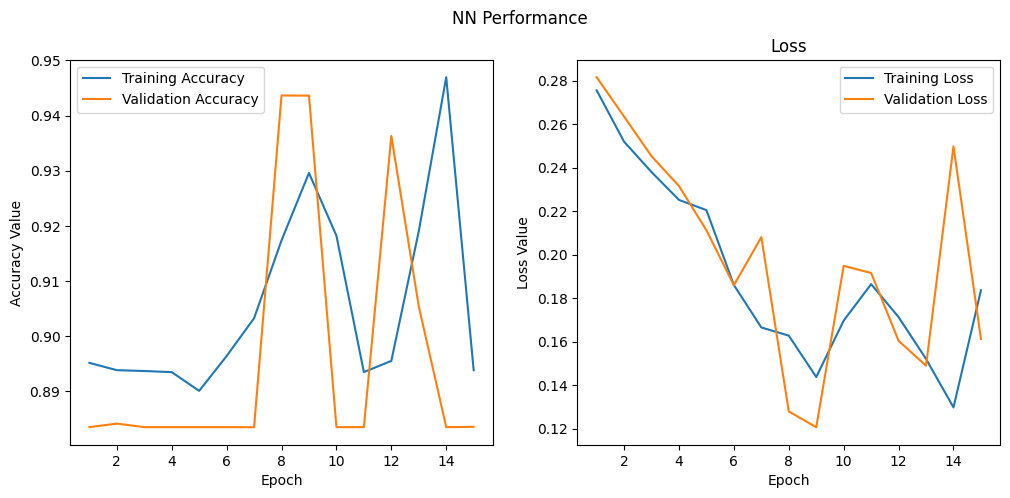

In [ ]:
epochs = range(1, len(hist2.history['accuracy']) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(epochs, hist2.history['accuracy'], label='Training Accuracy')
ax[0].plot(epochs, hist2.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy Value')
ax[0].legend()



ax[1].plot(epochs,hist2.history['loss'], label='Training Loss')
ax[1].plot(epochs, hist2.history['val_loss'], label='Validation Loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss Value')
ax[1].legend()

fig.suptitle('NN Performance')

plt.show();

## `v` It's Time for Segmentation!!

Let's try to predict the mask of some validation samples and plot the results.

In [ ]:
for images, masks in train_data.take(1):
    preds = model_u_net.predict(images)

    num_images = min(10, images.shape[0])
    fig, axes = plt.subplots(num_images, 5, figsize=(15, num_images * 3))

    for i in range(num_images):
        # Input image
        axes[i, 0].imshow(images[i].numpy().squeeze(), cmap='gray')
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis('off')

        # Ground Truth Mask
        axes[i, 1].imshow(masks[i].numpy().squeeze(), cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')

        # Predicted Mask
        pred_mask = preds[i].squeeze()
        pred_mask1 = (pred_mask > 0.2).astype(np.uint8)
        axes[i, 2].imshow(pred_mask1, cmap='gray')

        axes[i, 2].set_title("Prediction with threshold >0.3")
        axes[i, 2].axis('off')



        # Predicted Mask
        pred_mask = preds[i].squeeze()
        pred_mask2 = (pred_mask > 0.3).astype(np.uint8)
        axes[i, 3].imshow(pred_mask2, cmap='gray')

        axes[i, 3].set_title("Prediction with threshold >0.3")
        axes[i, 3].axis('off')


          # Predicted Mask
        pred_mask = preds[i].squeeze()
        pred_mask3 = (pred_mask > 0.4).astype(np.uint8)
        axes[i, 4].imshow(pred_mask3, cmap='gray')

        axes[i, 4].set_title("Prediction with threshold >0.4")
        axes[i, 4].axis('off')



    plt.tight_layout()
    plt.show()

**Note:** You can add more trials and explore different hyperparameters and design decisions as you want.

------------------------------

# Assignment 02
- Design your Deep Convolutional Neural Network using `Transfer Learning`
- You can select any pretrained model as a base and build on top.
- The task is to successfully classify images of cats and dogs using the dataset [here](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip).
- There are no constraint; you have **full power**.

## `+` Downlaod, Load & Preprocess Cats & Dogs Data

### Download & Extract the Dataset

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  73.9M      0  0:00:10  0:00:10 --:--:-- 87.4M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls -Rd PetImages/*

PetImages/Cat  PetImages/Dog


In [ ]:
# Delete Corrupted Images

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


In [ ]:
BATCH_SIZE=64

### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [ ]:
# Training & Validation
pet_train, pet_val = image_dataset_from_directory('PetImages',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(180,180),
                                                validation_split=0.2,
                                                subset="both")

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


### Augmentation

In [ ]:
def augment_data(images, layers):
    for layer in layers:
        images = layer(images)
    return images

In [ ]:
layers = [RandomFlip(), RandomRotation(0.2)]
augmented_train_ds = pet_train.map(lambda x, y: (augment_data(x, layers), y))

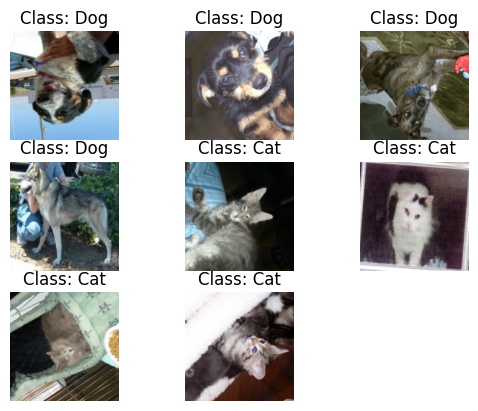

In [ ]:
for images, labels in augmented_train_ds.take(2):
  for i in range(8):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.array(images[i]).astype('uint8'))
    plt.title(f'Class: {["Cat", "Dog"][labels[i]]}')
    plt.axis('off')

### Preview the Images

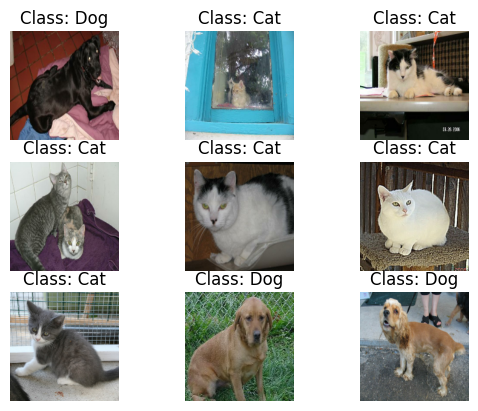

In [ ]:
for images, labels in pet_train.take(1):
  for i in range(min(9, images.shape[0])):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.array(images[i]).astype('uint8'))
    plt.title(f'Class: {["Cat", "Dog"][labels[i]]}')
    plt.axis('off')

## `+` Set Global Parameters

In [ ]:
# Hyperparameters
EPOCHS=15

## `i` Model Design

Design your Deep Convolutional Neural Network using Transfer Learning
You can select any pretrained model as a base and build on top.
The task is to successfully classify images of cats and dogs using the dataset here.
There are no constraint; you have full power.




In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [ ]:
pre_trained = MobileNetV2(include_top=False, pooling='avg', weights='imagenet')

<ipython-input-32-eb5cc02ea6f2>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained = MobileNetV2(include_top=False, pooling='avg', weights='imagenet')


In [ ]:
pre_trained.trainable = False

# `ii` Trail #1

## `ii` Model Compilation & Training

In [ ]:
model_pre1 = Sequential()
model_pre1.add(Input((180,180,3)))


model_pre1.add(pre_trained)

model_pre1.add(Dense(256, activation='relu'))
model_pre1.add(BatchNormalization())


model_pre1.add(Dense(128, activation='relu'))
model_pre1.add(BatchNormalization())


model_pre1.add(Dense(1, activation='sigmoid'))

model_pre1.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,620,481 (10.00 MB)

 Trainable params: 361,729 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

In [ ]:
model_pre1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_pre = model_pre1.fit(augmented_train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stopping], validation_data=pet_val)

Epoch 1/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 134s 411ms/step - accuracy: 0.6527 - loss: 0.6520 - val_accuracy: 0.6578 - val_loss: 0.6598
Epoch 2/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 115s 391ms/step - accuracy: 0.7006 - loss: 0.5740 - val_accuracy: 0.7067 - val_loss: 0.5601
Epoch 3/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 136s 372ms/step - accuracy: 0.7095 - loss: 0.5612 - val_accuracy: 0.6871 - val_loss: 0.6032
Epoch 4/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 107s 364ms/step - accuracy: 0.7074 - loss: 0.5656 - val_accuracy: 0.6984 - val_loss: 0.5779
Epoch 5/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 143s 369ms/step - accuracy: 0.7139 - loss: 0.5536 - val_accuracy: 0.7134 - val_loss: 0.5578
Epoch 6/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 108s 367ms/step - accuracy: 0.7176 - loss: 0.5506 - val_accuracy: 0.7087 - val_loss: 0.5595
Epoch 7/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 143s 371ms/step - accuracy: 0.7240 - loss: 0.5412 - val_accuracy: 0.7014 - val_loss: 0.5673
Epoch 8/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 149s 394ms/step - accuracy: 0.7244 -

## `iii` Model Evaluation

In [ ]:
loss_2,acc_2=model_pre1.evaluate(augmented_train_ds)
print(f"Accuracy training: {acc_2}")

loss_2,acc_val_2=model_pre1.evaluate(pet_val)
print(f"Accuracy validation: {acc_val_2}")

293/293 ━━━━━━━━━━━━━━━━━━━━ 105s 358ms/step - accuracy: 0.7402 - loss: 0.5261
Accuracy training: 0.734248161315918
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.7331 - loss: 0.5386
Accuracy validation: 0.7319521307945251


## `iv` Result Visualization

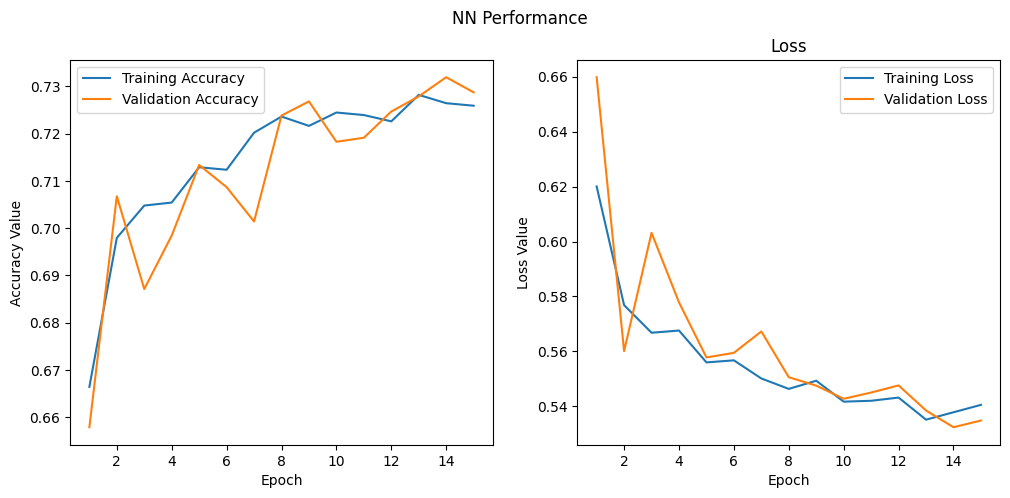

In [ ]:
epochs = range(1, len(history_pre.history['accuracy']) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(epochs, history_pre.history['accuracy'], label='Training Accuracy')
ax[0].plot(epochs, history_pre.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy Value')
ax[0].legend()



ax[1].plot(epochs,history_pre.history['loss'], label='Training Loss')
ax[1].plot(epochs, history_pre.history['val_loss'], label='Validation Loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss Value')
ax[1].legend()

fig.suptitle('NN Performance')

plt.show();

# `ii`Another Trail

In [ ]:
pre_trained2 = MobileNetV2((180, 180, 3),include_top=False, pooling='avg', weights='imagenet')

<ipython-input-41-1e81b4f256e3>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained2 = MobileNetV2((180, 180, 3),include_top=False, pooling='avg', weights='imagenet')


In [ ]:
pre_trained2.trainable = False

In [ ]:
EPOCHS=50

In [ ]:
BATCH_SIZE

64

## `ii` Model Compilation & Training

In [ ]:
model_pre2 = Sequential()

model_pre2.add(pre_trained2)


model_pre2.add(Dense(512, activation='relu'))
model_pre2.add(BatchNormalization())
model_pre2.add(Dropout(0.4))

model_pre2.add(Dense(256, activation='relu'))
model_pre2.add(BatchNormalization())
model_pre2.add(Dropout(0.4))


model_pre2.add(Dense(128, activation='relu'))
model_pre2.add(BatchNormalization())
model_pre2.add(Dropout(0.4))

model_pre2.add(Dense(1, activation='sigmoid'))

model_pre2.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,081,793 (11.76 MB)

 Trainable params: 822,017 (3.14 MB)

 Non-trainable params: 2,259,776 (8.62 MB)

In [ ]:
model_pre2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_pre2 = model_pre2.fit(augmented_train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stopping], validation_data=pet_val)

Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 135s 418ms/step - accuracy: 0.5575 - loss: 0.8685 - val_accuracy: 0.6271 - val_loss: 0.6468
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 109s 371ms/step - accuracy: 0.6091 - loss: 0.7505 - val_accuracy: 0.6544 - val_loss: 0.6270
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 143s 375ms/step - accuracy: 0.6260 - loss: 0.7139 - val_accuracy: 0.6747 - val_loss: 0.6123
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 143s 377ms/step - accuracy: 0.6364 - loss: 0.6861 - val_accuracy: 0.6865 - val_loss: 0.6000
Epoch 5/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 111s 379ms/step - accuracy: 0.6426 - loss: 0.6701 - val_accuracy: 0.6912 - val_loss: 0.5967
Epoch 6/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 111s 378ms/step - accuracy: 0.6471 - loss: 0.6580 - val_accuracy: 0.6986 - val_loss: 0.5858
Epoch 7/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 108s 369ms/step - accuracy: 0.6508 - loss: 0.6459 - val_accuracy: 0.6897 - val_loss: 0.5929
Epoch 8/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 142s 368ms/step - accuracy: 0.6600 -

## `iii` Model Evaluation

In [ ]:
loss_,acc_2_train=model_pre2.evaluate(augmented_train_ds)
print(f"Accuracy training: {acc_2_train}")

loss__,acc_2_val=model_pre2.evaluate(pet_val)
print(f"Accuracy validation: {acc_2_val}")

293/293 ━━━━━━━━━━━━━━━━━━━━ 107s 364ms/step - accuracy: 0.7345 - loss: 0.5268
Accuracy training: 0.7285348176956177
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.7298 - loss: 0.5454
Accuracy validation: 0.7306706309318542


## `iv` Result Visualization

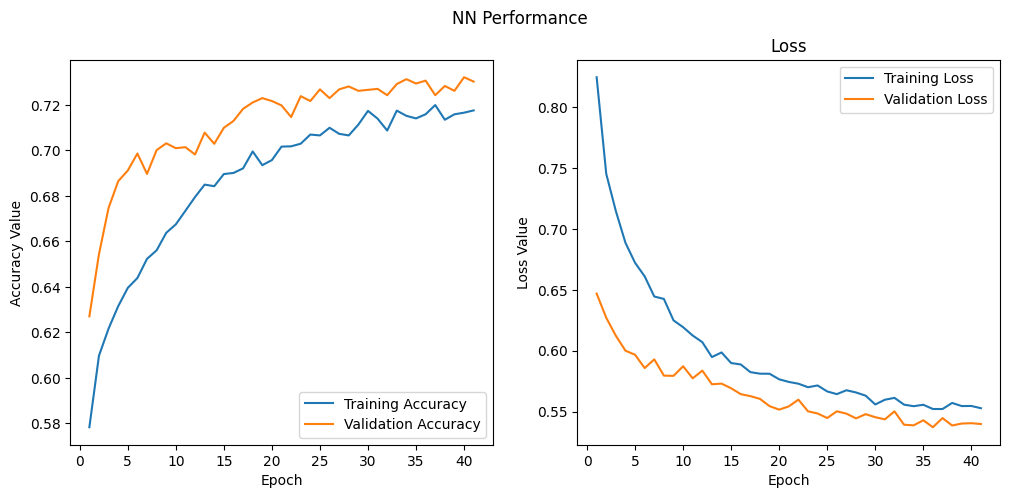

In [ ]:
epochs = range(1, len(history_pre2.history['accuracy']) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(epochs, history_pre2.history['accuracy'], label='Training Accuracy')
ax[0].plot(epochs, history_pre2.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy Value')
ax[0].legend()



ax[1].plot(epochs,history_pre2.history['loss'], label='Training Loss')
ax[1].plot(epochs, history_pre2.history['val_loss'], label='Validation Loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss Value')
ax[1].legend()

fig.suptitle('NN Performance')

plt.show();

## `v` Let's Test Our Model

Let's try to predict the class of some validation samples and plot the results.

Also, try to classify an image from the internet.

**Note:** remember to properly process the image (dimensions, rescaling, etc.)

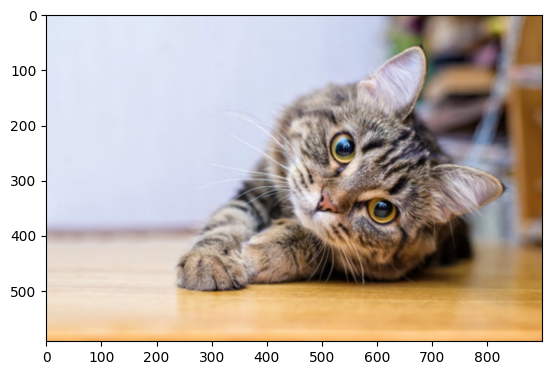

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/test_image.jpg')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
img = img / 255.0
img = tf.image.resize(img, [180, 180])
img = np.expand_dims(img, axis=0)

In [ ]:
prediction=model_pre2.predict([img])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [ ]:
true_label='Cat'

In [ ]:
if prediction[0] > 0.5:
  predicted_label = 'Dog'
else:
  predicted_label = 'Cat'

Text(0.5, 1.0, 'Actual: Cat\nPredicted: Cat')

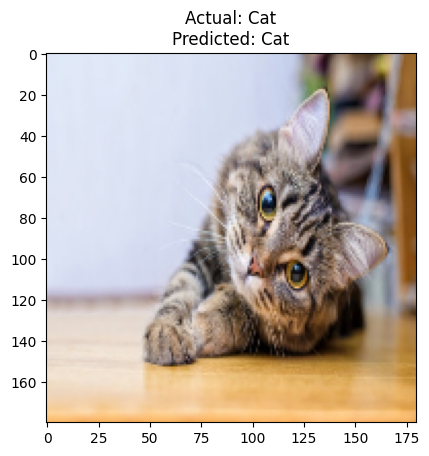

In [ ]:
# Plot the Input, True Label, and Predicted Label
labels = ["Cat", "Dog"]
plt.imshow(img[0])
plt.title(f"Actual: {true_label}\nPredicted: {predicted_label}")

----------------------------------------------

$$ Wish \space you \space all \space the \space best \space ♡ $$
$$ Abdelrahman \space Eid $$

# `ii`Another Trail 2

In [ ]:
pre_trained3 = MobileNetV2((180, 180, 3),include_top=False, pooling='avg', weights='imagenet')

<ipython-input-41-1e81b4f256e3>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained2 = MobileNetV2((180, 180, 3),include_top=False, pooling='avg', weights='imagenet')


In [ ]:
pre_trained3.trainable = False

In [ ]:
EPOCHS=50

In [ ]:
BATCH_SIZE=128

64

## `ii` Model Compilation & Training

In [ ]:
model_pre3 = Sequential()

model_pre3.add(pre_trained3)


model_pre3.add(Dense(512, activation='relu'))
model_pre3.add(BatchNormalization())
model_pre3.add(Dropout(0.4))

model_pre3.add(Dense(256, activation='relu'))
model_pre3.add(BatchNormalization())
model_pre3.add(Dropout(0.4))


model_pre3.add(Dense(128, activation='relu'))
model_pre3.add(BatchNormalization())
model_pre3.add(Dropout(0.4))

model_pre3.add(Dense(1, activation='sigmoid'))

model_pre3.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,081,793 (11.76 MB)

 Trainable params: 822,017 (3.14 MB)

 Non-trainable params: 2,259,776 (8.62 MB)

In [ ]:
model_pre3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_pre3 = model_pre3.fit(augmented_train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stopping], validation_data=pet_val)

Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 135s 418ms/step - accuracy: 0.5575 - loss: 0.8685 - val_accuracy: 0.6271 - val_loss: 0.6468
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 109s 371ms/step - accuracy: 0.6091 - loss: 0.7505 - val_accuracy: 0.6544 - val_loss: 0.6270
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 143s 375ms/step - accuracy: 0.6260 - loss: 0.7139 - val_accuracy: 0.6747 - val_loss: 0.6123
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 143s 377ms/step - accuracy: 0.6364 - loss: 0.6861 - val_accuracy: 0.6865 - val_loss: 0.6000
Epoch 5/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 111s 379ms/step - accuracy: 0.6426 - loss: 0.6701 - val_accuracy: 0.6912 - val_loss: 0.5967
Epoch 6/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 111s 378ms/step - accuracy: 0.6471 - loss: 0.6580 - val_accuracy: 0.6986 - val_loss: 0.5858
Epoch 7/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 108s 369ms/step - accuracy: 0.6508 - loss: 0.6459 - val_accuracy: 0.6897 - val_loss: 0.5929
Epoch 8/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 142s 368ms/step - accuracy: 0.6600 -

## `iii` Model Evaluation

In [ ]:
loss_3,acc_3_train=model_pre3.evaluate(augmented_train_ds)
print(f"Accuracy training: {acc_3_train}")

loss_3,acc_3_val=model_pre2.evaluate(pet_val)
print(f"Accuracy validation: {acc_3_val}")

293/293 ━━━━━━━━━━━━━━━━━━━━ 107s 364ms/step - accuracy: 0.7345 - loss: 0.5268
Accuracy training: 0.7285348176956177
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.7298 - loss: 0.5454
Accuracy validation: 0.7306706309318542


## `iv` Result Visualization

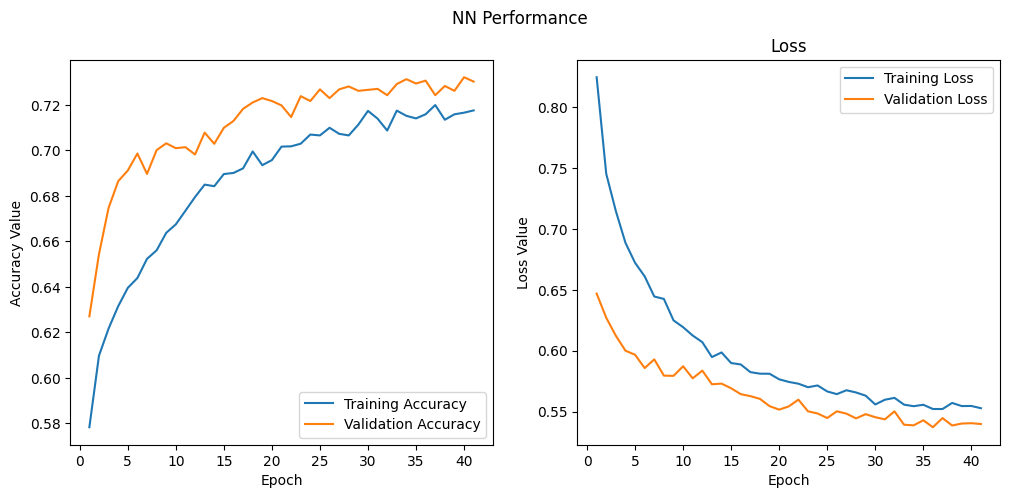

In [ ]:
epochs = range(1, len(history_pre3.history['accuracy']) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(epochs, history_pre3.history['accuracy'], label='Training Accuracy')
ax[0].plot(epochs, history_pre3.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy Value')
ax[0].legend()



ax[1].plot(epochs,history_pre3.history['loss'], label='Training Loss')
ax[1].plot(epochs, history_pre3.history['val_loss'], label='Validation Loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss Value')
ax[1].legend()

fig.suptitle('NN Performance')

plt.show();

## `v` Let's Test Our Model

Let's try to predict the class of some validation samples and plot the results.

Also, try to classify an image from the internet.

**Note:** remember to properly process the image (dimensions, rescaling, etc.)

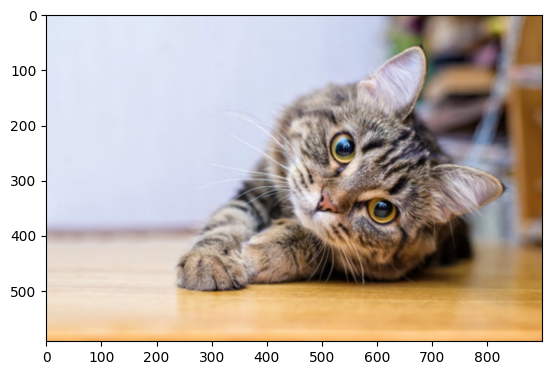

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/test_image.jpg')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
img = img / 255.0
img = tf.image.resize(img, [180, 180])
img = np.expand_dims(img, axis=0)

In [ ]:
prediction=model_pre2.predict([img])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [ ]:
true_labels = {
    'cat1.jpg': 'Cat',
    'dog3.jpg': 'Dog',
    # add more if needed
}

In [ ]:
if prediction[0] > 0.5:
  predicted_label = 'Dog'
else:
  predicted_label = 'Cat'

Text(0.5, 1.0, 'Actual: Cat\nPredicted: Cat')

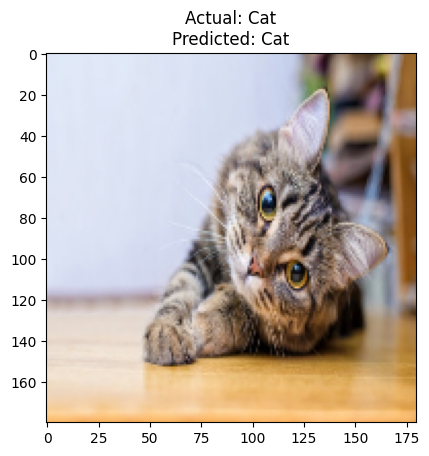

In [ ]:
# Plot the Input, True Label, and Predicted Label
labels = ["Cat", "Dog"]
plt.imshow(img[0])
plt.title(f"Actual: {true_label}\nPredicted: {predicted_label}")

----------------------------------------------

$$ Wish \space you \space all \space the \space best \space ♡ $$
$$ Abdelrahman \space Eid $$